In [1]:
from typing import List, Any
Shape = Any


In [103]:
from functools import lru_cache
import sys
import os
import glob
import time

import dlib
from scipy.spatial import distance as dist
import cv2
from matplotlib import pyplot
import tqdm.notebook
import ipywidgets as wg
import IPython.core.display
import numpy

from IPython.lib import backgroundjobs

HOME = os.environ['HOME']

In [ ]:
jobs = backgroundjobs.BackgroundJobManager()


In [3]:
# If this is broken then patch $VIRTUAL_ENV/lib/python3.7/site-packages/faced/detector.py
# as described in https://github.com/iitzco/faced/issues/27 and then:
#     del sys.modules["faced.detector"]
#     del sys.modules["faced"]
# so that it reloads when you import it again.
# import faced


In [4]:
predictor_path = 'shape_predictor_68_face_landmarks.dat'
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)


In [5]:
@lru_cache(maxsize=1000_000)
def detect(filename) -> List[Shape]:
    img = dlib.load_rgb_image(filename)
    dets = detector(img, 1)
    shapes = []
    for d in dets:
        shape = predictor(img, d)
        shapes.append(shape)
    return shapes




face_detector = faced.FaceDetector()

def to_rectangles(bboxes):
    rectangles = dlib.rectangles()
    for (x_center, y_center, width, height, prob) in bboxes:
        rectangle = dlib.rectangle(
            x_center - (width//2),
            y_center - (height//2),
            x_center + (width//2),
            y_center + (height//2),
        )
        rectangles.append(rectangle)
    return rectangles

@lru_cache(maxsize=1000_000)
def detect_both_ways(filename):
    img = dlib.load_rgb_image(filename)
    dets = detector(img, 1)

    img = cv2.imread(filename)
    rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

    # Receives RGB numpy image (HxWxC) and
    # returns (x_center, y_center, width, height, prob) tuples. 
    bboxes = face_detector.predict(rgb_img)
    return dets, to_rectangles(bboxes)



@lru_cache(maxsize=1000_000)
def detect2(filename):
    img = cv2.imread(filename)
    rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    bboxes = face_detector.predict(rgb_img)
    rectangles = to_rectangles(bboxes)
    faces = []
    for d in rectangles:
        face = predictor(img, d)
        if valid(face, img.shape):
            faces.append(face)
    return faces

In [6]:
# see https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/
import cv2
import time
import sys


def detectFaceOpenCVDnn(net, frame):
    conf_threshold = 0.8
    
    frameOpencvDnn = frame.copy()
    frameHeight = frameOpencvDnn.shape[0]
    frameWidth = frameOpencvDnn.shape[1]
    blob = cv2.dnn.blobFromImage(frameOpencvDnn, 1.0, (300, 300), [104, 117, 123], False, False)

    net.setInput(blob)
    detections = net.forward()
    bboxes = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > conf_threshold:
            x1 = int(detections[0, 0, i, 3] * frameWidth)
            y1 = int(detections[0, 0, i, 4] * frameHeight)
            x2 = int(detections[0, 0, i, 5] * frameWidth)
            y2 = int(detections[0, 0, i, 6] * frameHeight)
            bboxes.append((confidence, [x1, y1, x2, y2]))
            cv2.rectangle(frameOpencvDnn, (x1, y1), (x2, y2), (0, 255, 0), int(round(frameHeight/150)), 8)
    return frameOpencvDnn, bboxes

@lru_cache()
def initOpenCVDnn():
    modelFile = "learnopencv/FaceDetectionComparison/models/res10_300x300_ssd_iter_140000_fp16.caffemodel"
    configFile = "learnopencv/FaceDetectionComparison/models/deploy.prototxt"
    net = cv2.dnn.readNetFromCaffe(configFile, modelFile)
    
    return net

@lru_cache(maxsize=1000_000)
def detect_dnn_with_scores(filename):
    net = initOpenCVDnn()
    img = cv2.imread(filename)
#     rgb_img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    outOpencvDnn, bboxes = detectFaceOpenCVDnn(net,img)
    
    faces = []
    for score, bbox in bboxes:
        face = predictor(img, dlib.rectangle(*bbox))
        if valid(face, img.shape):
            faces.append((score, face))
    return faces


def detect_dnn(filename):
    return [face for (_, face) in detect_dnn_with_scores(filename)]

In [7]:
def valid(face, shape=(1920, 3840, 3)):
    y, x, *_channels = shape
    return any((point.x < x and point.y < y) for point in face.parts())

def only_valid(faces, shape=(1920, 3840, 3)):
    return [
        face for face in faces
        if valid(face, shape)
    ]

def only_invalid(faces, shape=(1920, 3840, 3)):
    return [
        face for face in faces
        if not valid(face, shape)
    ]

In [8]:
def detect_with_fallbacks(filename):
    return detect_dnn(filename) # or detect2(filename) # or detect(filename)

In [82]:
def eye_aspect_ratio(eye):
    # compute the euclidean distances between the two sets of
    # vertical eye landmarks (x, y)-coordinates
    A =  dlib.length(eye[1] - eye[5])
    B =  dlib.length(eye[2] - eye[4])
 
    # compute the euclidean distance between the horizontal
    # eye landmark (x, y)-coordinates
    C = dlib.length(eye[0] - eye[3]) or 100000000000000000.0
 
    # compute the eye aspect ratio
    ratio = (A + B) / (2.0 * C)
 
    # return the eye aspect ratio
    return ratio

In [52]:
FACIAL_LANDMARKS_IDXS = dict([
    ("mouth", (48, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 35)),
    ("jaw", (0, 17))
])


if False:
    def eye_aspect_ratio(eye):
        # compute the euclidean distances between the two sets of
        # vertical eye landmarks (x, y)-coordinates
        A =  dlib.length(eye[1] - eye[5])
        B =  dlib.length(eye[2] - eye[4])

        # compute the euclidean distance between the horizontal
        # eye landmark (x, y)-coordinates
        C = dlib.length(eye[0] - eye[3]) or 100000000000000000.0

        # compute the eye aspect ratio
        ratio = (A + B) / (2.0 * C)

        # return the eye aspect ratio
        return ratio

def max_eye_aspect_ratio(faces):
    max_ratio = 0
    for face in faces:
        for part in ("left_eye", "right_eye"):
            start, end = FACIAL_LANDMARKS_IDXS[part]
            eye = face.parts()[start:end]
            ratio = eye_aspect_ratio(eye)
            max_ratio = max([ratio, max_ratio])
    return max_ratio

@lru_cache(maxsize=1000_000)
def eye_score_for_file(filename):
    return max_eye_aspect_ratio(detect_with_fallbacks(filename))

def max_face_size(faces):
    max_size = 0
    for face in faces:
        parts = face.parts()
        size = 0
        size += dlib.length(parts[1] - parts[17])
        size += dlib.length(parts[2] - parts[16])
        size += dlib.length(parts[3] - parts[15])
        max_size = max([size, max_size])
    return max_size

def face_score_for_file(filename):
    return max_face_size(detect_with_fallbacks(filename))
    

In [10]:
def detected_filename(filename):
    return filename\
        .replace('.jpeg', '.jpg')\
        .replace('.jpg', '.detected.jpg')\
        .replace('.jpg.jpg', '.jpg')


@lru_cache(maxsize=1000_000)
def save_face_chip(filename):
    faces = detect_with_fallbacks(filename)
    if not len(faces):
        return filename

    img = dlib.load_rgb_image(filename)
    faces = only_valid(faces, img.shape)
    if not len(faces):
        return filename
    scores = [max_eye_aspect_ratio([face]) for face in faces]

    best_face = max(zip(scores, enumerate(faces)))[-1][-1]
    
    for part in ("left_eye", "right_eye"):
        start, end = FACIAL_LANDMARKS_IDXS[part]
        eye = best_face.parts()[start:end]
        for pointa, pointb in zip(eye, list(eye[1:])+list(eye[:1])):
            cv2.line(img, (pointa.x, pointa.y),(pointb.x, pointb.y), (255,0,255), 5)
#     dlib.save_image(img, filename.replace('.jpeg', '.detected.jpg'))
    dlib.save_face_chip(img, best_face, detected_filename(filename)[:-4])
    return detected_filename(filename)


In [12]:
@lru_cache(maxsize=1000_000)
def save_broken_face_chip(filename):
    faces = only_invalid(detect_with_fallbacks(filename))
    scores = [max_eye_aspect_ratio([face]) for face in faces]
    if len(faces):
        best_face = max(zip(scores, enumerate(faces)))[-1][-1]
        img = dlib.load_rgb_image(filename)
        dlib.save_face_chip(img, best_face, filename.replace('.jpeg', '.jpg').replace('.jpg', '.funky'))
        return filename.replace('.jpeg', '.jpg').replace('.jpg', '.funky.jpg')
    return filename

In [135]:
broken_filenames={}

In [153]:
# faces_folder_path = f'{HOME}/tmp/*x*/*/*.mp4.images/'
faces_folder_path = f'{HOME}/src/eye-tracking/betterthumbs/*/'

@lru_cache(maxsize=1)
def get_filenames():
    return list(
        f for f in sorted(glob.glob(os.path.join(faces_folder_path, "*.jpg")))
        if '/tmp/3840x1920/1.mp4' not in f
        and 'detected' not in f
        and '.jpg.jpg' not in f
    #     and '1920x1080/1080P_4000K_236777331.mp4' in f
    )

def warm_caches(step=1, smoke=False):
    start = time.time()
    for filename in tqdm.notebook.tqdm(get_filenames()[::step]): #[126:][:1]:
        try:
            shapes = detect_with_fallbacks(filename)
            if len(shapes) and 0.5 > eye_score_for_file(filename) > 0.25:
                save_face_chip(filename)
        except (AttributeError, ZeroDivisionError, TypeError, ValueError) as e:
            broken_filenames[filename] = e
        else:
            if smoke and time.time() - start > 10:
                break
           

def warm_caches_backwards():
    warm_caches(-1)
    
warm_caches(smoke=True) 

# jobs.new(warm_caches)
# jobs.new(warm_caches_backwards)


In [159]:
" warm_caches " in str(jobs.running) or jobs.new(warm_caches)
" warm_caches_backwards " in str(jobs.running) or jobs.new(warm_caches_backwards)


<BackgroundJob #27: <function warm_caches_backwards at 0x139221c20>>

In [155]:
" warm_caches " in str(jobs.running) or jobs.new(warm_caches)
" warm_caches_backwards " in str(jobs.running) or jobs.new(warm_caches_backwards)


<BackgroundJob #25: <function warm_caches_backwards at 0x139221c20>>

In [156]:
warm_caches_backwards()


In [34]:
def get_face_filenames():
    return list(
        sorted(
            [
                filename for filename in get_filenames()
                if True
    #             and ('1920x1080'  in filename)
                and 0.5 > eye_score_for_file(filename) > 0.25 

    #             and '1920x1080/1080P_4000K_236777331.mp4' in filename
    #             and only_invalid(detect_with_fallbacks(filename))
            ],
    #         key=face_score_for_file,
        )
    )

def show_face(x):
    filename = get_face_filenames()[x]
    facename = detected_filename(filename)
    shapes = detect_with_fallbacks(filename)
    print(len(shapes), len(detect(filename)), filename.replace(HOME, '~'))
    print(eye_score_for_file(filename))
    print(face_score_for_file(filename))
    
    if len(shapes):
        print([s for (s,_) in detect_dnn_with_scores(filename)])
        filename = save_face_chip(filename)
    widget = IPython.core.display.Image(filename=filename)
    return widget

maxf = len(get_face_filenames()) - 1
wg.interact(show_face, x=(1,maxf));


interactive(children=(IntSlider(value=149, description='x', max=298, min=1), Output()), _dom_classes=('widget-…

In [16]:
len(get_face_filenames()) , len(get_filenames())

(299, 1344)

In [57]:
from collections import Counter
totals_breakdown = Counter(filename.rsplit(')', 1)[0] for filename in get_filenames() if 'Interactive' in filename)
# totals_breakdown

faces_breakdown = Counter(filename.rsplit(')', 1)[0] for filename in get_face_filenames() if 'Interactive' in filename)
# faces_breakdown

best = sorted([
        (faces_breakdown[k]/totals_breakdown[k], k.replace('.images/', '.hls/out.m3u8').replace(HOME, '~'))
        for k in totals_breakdown.keys()
        if totals_breakdown[k] > 5
    ], reverse=True)
best

[(0.6875,
  '~/src/eye-tracking/morethumbs/Interactive/(m=eaAaGwObaaaa)(mh=SL9_onpG4PqXRrkc'),
 (0.6363636363636364,
  '~/src/eye-tracking/morethumbs/Interactive/(m=q3545PUbeaAaGwObaaaa)(mh=2YJMWG_YkfCO7sqJ'),
 (0.5625,
  '~/src/eye-tracking/morethumbs/Interactive/(m=eaAaGwObaaaa)(mh=H2_htFQTKi7EJG33'),
 (0.5294117647058824,
  '~/src/eye-tracking/morethumbs/Interactive/(m=eaAaGwObaaaa)(mh=PVWVyUlByd1Pc_XK'),
 (0.4375,
  '~/src/eye-tracking/morethumbs/Interactive/(m=eaAaGwObaaaa)(mh=z2cgJfQZBH5YpoJt'),
 (0.4375,
  '~/src/eye-tracking/morethumbs/Interactive/(m=eaAaGwObaaaa)(mh=X2NHUgDRRYZ6V48m'),
 (0.4375,
  '~/src/eye-tracking/morethumbs/Interactive/(m=eaAaGwObaaaa)(mh=Rl51KiLdZZDWOGax'),
 (0.4375,
  '~/src/eye-tracking/morethumbs/Interactive/(m=eaAaGwObaaaa)(mh=GulQqgLRxPVmZ-6I'),
 (0.4117647058823529,
  '~/src/eye-tracking/morethumbs/Interactive/(m=qG89NQUbeaAaGwObaaaa)(mh=06YI75vTxEypJ8Ej'),
 (0.375,
  '~/src/eye-tracking/morethumbs/Interactive/(m=eaAaGwObaaaa)(mh=z6vVVdR11m-5_sWy'),

In [ ]:
import os

def to_keyframe_filename(ts_filename):
    return ts_filename.replace(
        'segment', 'keyframe'
    ).replace(
        '.ts\n', '.jpeg'
    )

def make_filtered_playlist(
    original_playlist_filename,
    filter_function,
    output_filename='filtered.m3u8',
):
    out = []
    chunks: Tuple[str, str] = []
    chunk_start: Optional[str] = None
    with open(original_playlist_filename) as f:
    
        lines = iter(f)
        for line in lines:
            if line.startswith('#EXTINF'):
                chunk_start = line
                break
            out.append(line)

        for line in lines:
            if chunk_start is not None:
                chunks.append((chunk_start, line))
                chunk_start = None
            elif line.startswith('#EXTINF'):
                chunk_start = line
            else:
                # really I should use a peekable iterator, or put line back on
                # the front of lines, but nevermind.
                trailing_line = line
                break
        else:
            trailing_line = ''

        chunks = [
            chunk
            for chunk in chunks
            if filter_function(
                original_playlist_filename.replace(
                    '.hls/out.m3u8', 
                    '.images/' + to_keyframe_filename(chunk[-1])
                )
            )
        ]

        for chunk in chunks:
            out.extend(chunk)
            # Credit to @DHE in #ffmpeg on freenode for suggesting
            # #EXT-X-DISCONTINUITY.
            # https://developer.apple.com/documentation/http_live_streaming/example_playlists_for_http_live_streaming/incorporating_ads_into_a_playlist
            out.append('#EXT-X-DISCONTINUITY\n')
        # strip the #EXT-X-DISCONTINUITY from after the last chunk
        out.pop()
        out.append(trailing_line)

        for line in lines:
            out.append(line)

    filtered_filename = original_playlist_filename.replace('out.m3u8', output_filename)
    with open(filtered_filename,'w',) as f:
        f.write(''.join(out)+'\n')
    return filtered_filename.replace(HOME, '~')
        

def has_eye_contact(filename):
    if not os.path.exists(filename):
        return False
    return 0.5 > eye_score_for_file(filename) > 0.25

def has_no_eye_contact(filename):
    if not os.path.exists(filename):
        return False
    return eye_score_for_file(filename) < 0.25

for _score, filename in best:
    print(make_filtered_playlist(
        filename.replace('~', HOME),
        has_eye_contact,
        'filtered.m3u8'
    ))
    print(make_filtered_playlist(
        filename.replace('~', HOME),
        has_no_eye_contact,
        'rejected.m3u8'
    ))

In [ ]:
faces = [
    (filename, face)
    for filename in face_filenames
#         if ('1920x1080/1080P_4000K_236777331.mp4' in filename)
            for face in detect_with_fallbacks(filename)
#                 if not any((point.x < 1920 and point.y < 1080) for point in face.parts())
]


In [ ]:
pyplot.figure()
for filename, face in faces:
    points = [
        (point.x, -point.y)
        for point in face.parts()
    ]
    pyplot.scatter(*zip(*points), label=filename.replace(HOME, '~'))
# pyplot.legend()

In [ ]:
pyplot.figure()
eyes = [
    (
        eye_score_for_file(filename),
        max((i for (i, _) in detect_dnn_with_scores(filename)), default=0)
    )
    for (i, filename) in enumerate(files)
    if 'Beertje96' in filename
]
pyplot.plot(eyes, linestyle='', marker='.')
pyplot.legend()

In [ ]:
pyplot.plot?


In [ ]:
max?

In [ ]:
len(face.parts())


In [162]:
[j.join() for j in jobs.running]

[None, None]

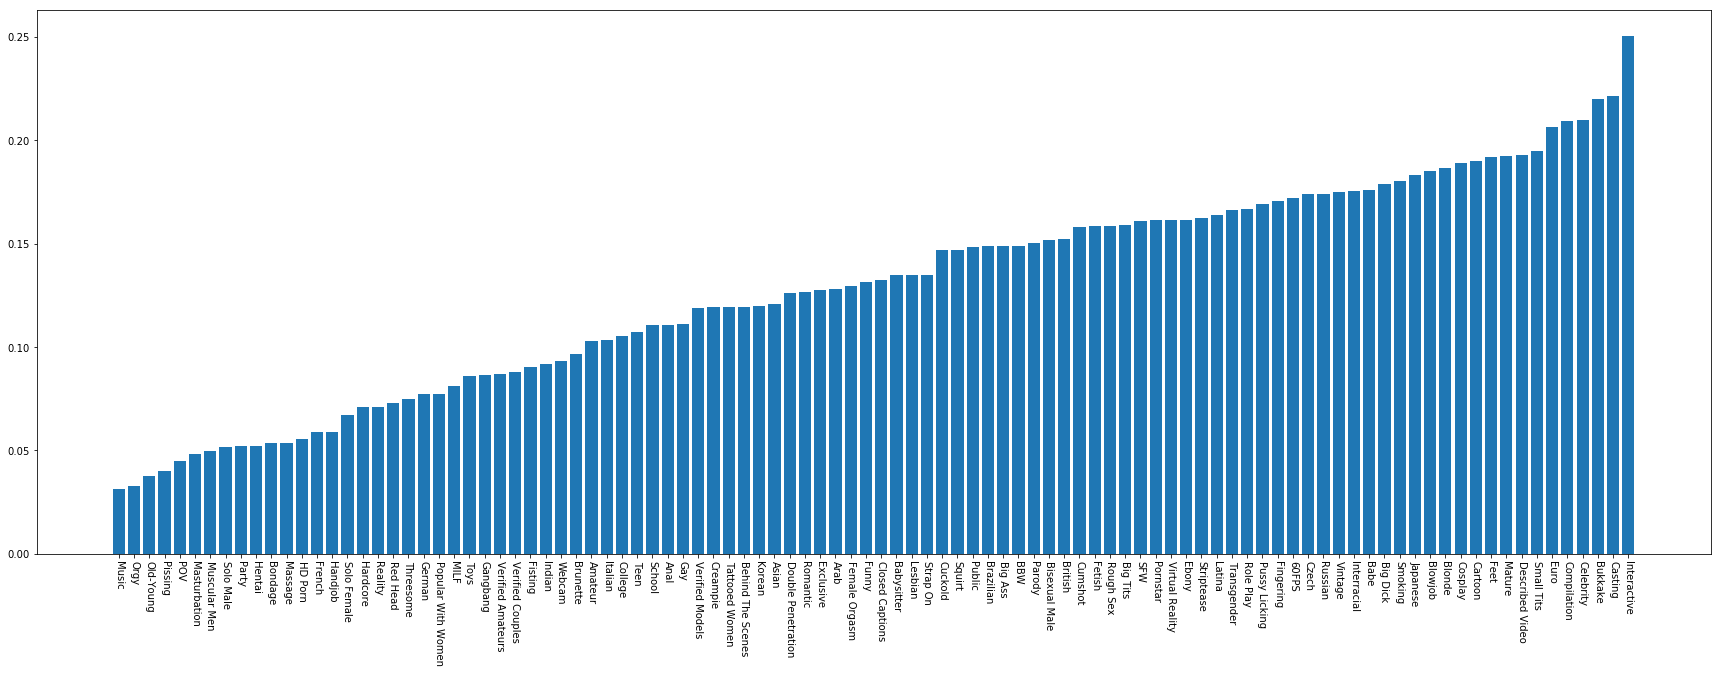

In [163]:
pyplot.figure(figsize=(30,10))

totals = []
faces = []
labels = []
to_plot = []
for folder in glob.glob(faces_folder_path):
    category = folder.rsplit('/')[-2]
#     print(category)
    total = len([f for f in get_filenames() if folder in f])
    if total > 500:
        totals.append(total)
        face_count = len([f for f in get_face_filenames() if folder in f])
        faces.append(face_count)
        labels.append(category)
        to_plot.append((face_count / total, category))

height, labels = zip(*sorted(to_plot))
# bars = labels
# height = faces
y_pos = numpy.arange(len(labels))

# pyplot.scatter(totals, faces)
pyplot.bar(y_pos, height)
pyplot.xticks(y_pos, labels, rotation=-90)

None
    

In [158]:
get_filenames.cache_clear()
bad = []
for folder in glob.glob(faces_folder_path):
    category = folder.rsplit('/')[-2]
#     print(category)
    total = len([f for f in get_filenames() if folder in f])
    if total < 500:
        bad.append((total, category))
        
print(list(sorted(bad)))

[]
